$$ \eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 + \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right) $$


$$ \eta_t $$  is the learning rate 
$$ T_{\text{cur}} $$  is the number of epochs since the last restart 

In [1]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [47]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from operator import attrgetter,itemgetter
from functools import partial
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from torch.optim import Optimizer
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [39]:
import math

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/andres/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [86]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [87]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [82]:
pg = opt.param_groups[0]
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [83]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [84]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

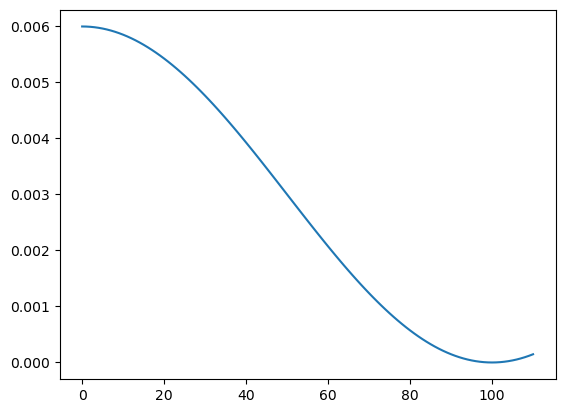

In [85]:
sched_lrs(sched,110)

For the COSINEANNEALINGLR we need parameters: `optimizer`,`Maximun iterations`,`last_epoch` cumplying with pytoch API

# first attempt

$$ \eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 + \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right) $$

In [ ]:
def CosAni(opt,max_it,last_epoch):
    if not isinstance(opt,Optimizer):
        raise TypeError(f'wrong type {type(optimizer).__name__}')
    lr_max = opt.param_groups[0]['initial_lr']

In [88]:
class CosAni:
    def __init__(self,opt,max_it,last_epoch = -1):
        if not isinstance(opt,Optimizer):
            raise TypeError(f'wrong type {type(optimizer).__name__}')
        self.optimizer=opt
        self.eta_max = opt.param_groups[0]['lr']
        self.eta_min = 0
        self.T_cur=0
        self.T_max=max_it
        self.current_lr = opt.param_groups[0]['lr']
    ## you need to run this function after optimizer step
    def step(self):
        self.current_lr= self.eta_min + 1/2*(self.eta_max-self.eta_min)*(1+math.cos(self.T_cur/self.T_max * math.pi))
        print(f'new_lr = {self.current_lr}')
        self.T_cur+=1
        ##self.optimizer.param_groups[0]['lr'] = self.current_lr
    def get_last_lr(self):
        return  self.current_lr
        
        

In [89]:
sched2 = CosAni(opt,100)

new_lr = 0.006
new_lr = 0.005998519681097195
new_lr = 0.005994080185284815
new_lr = 0.00598668589380924
new_lr = 0.005976344103943434
new_lr = 0.005963065021785414
new_lr = 0.005946861752186066
new_lr = 0.005927750285816242
new_lr = 0.005905749483385893
new_lr = 0.005880881057030829
new_lr = 0.0058531695488854615
new_lr = 0.005822642306862677
new_lr = 0.005789329457664754
new_lr = 0.005753263877051943
new_lr = 0.0057144811573980586
new_lr = 0.0056730195725651035
new_lr = 0.005628920040131591
new_lr = 0.005582226081011831
new_lr = 0.005532983776506045
new_lr = 0.005481241722823685
new_lr = 0.005427050983124842
new_lr = 0.005370465037127071
new_lr = 0.005311539728327368
new_lr = 0.005250333208891379
new_lr = 0.005186905882264235
new_lr = 0.005121320343559642
new_lr = 0.005053641317786066
new_lr = 0.004983935595970956
new_lr = 0.004912271969246069
new_lr = 0.00483872116095893
new_lr = 0.00476335575687742
new_lr = 0.004686250133556392
new_lr = 0.00460748038493699
new_lr = 0.004527124247251

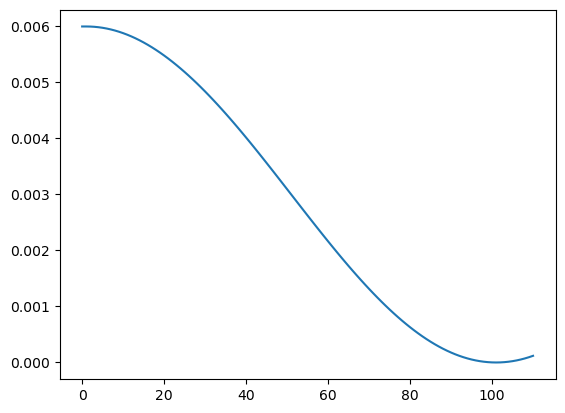

In [90]:
sched_lrs(sched2,110)